# Utility Functions

In [1]:
import tensorflow as tf
import numpy as np
import json
import re
from tensorflow.contrib.rnn import GRUCell
from tensorflow.python.ops.rnn import bidirectional_dynamic_rnn as bi_rnn
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange as trange
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import nltk
from nltk.stem.porter import *
from nltk import word_tokenize
import pickle
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr

nltk.download('punkt')
ps = PorterStemmer()
regex = re.compile('[^a-zA-Z]')

[nltk_data] Downloading package punkt to /home/john/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def process_word(word):
    if 'http' in word:
        return 'TOKEN_HTTP_URL'
    if 'ftp' in word:
        return 'TOKEN_FTP_URL'
    if '@' in word:
        return 'TOKEN_AT_REFERENCE'
    word = word.lower()
    word = regex.sub('',word)
    word = ps.stem(word)
    return word

def zero_pad(X, seq_len):
    return np.array([x[:seq_len - 1] + [0] * max(seq_len - len(x), 1) for x in X])


def get_vocabulary_size(X):
    return max([max(x) for x in X]) + 1  # plus the 0th word


def fit_in_vocabulary(X, voc_size):
    return [[w for w in x if w < voc_size] for x in X]

def batch_generator(X, y, batch_size):
    size = X.shape[0]
    X_copy = X.copy()
    y_copy = y.copy()
    indices = np.arange(size)
    np.random.shuffle(indices)
    X_copy = X_copy[indices]
    y_copy = y_copy[indices]
    i = 0
    while True:
        if i + batch_size <= size:
            yield X_copy[i:i + batch_size], y_copy[i:i + batch_size]
            i += batch_size
        else:
            i = 0
            indices = np.arange(size)
            np.random.shuffle(indices)
            X_copy = X_copy[indices]
            y_copy = y_copy[indices]
            continue

# Feature Extractors

In [3]:
# glove_loaded = False

# def load_glove():
#     model = dict()
#     print("Loading Glove")
#     glove2word2vec('glove.txt', 'word2vec.txt') #input glove.txt, output word2vec.txt
#     model = KeyedVectors.load_word2vec_format('word2vec.txt', binary=False)
#     glove_loaded = True
#     print("Glove Loaded. Testing: (expected output \"queen\")")
#     print(model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1))
#     return model

# def glove(comment, vocabulary):
#     if not glove_loaded:
#         model = load_glove()
#     body = comment['body']
#     x = []
#     for word in body.split():
#         if word in model.keys():
#             word = process_word(word)
#             x.append(model[word])
#     y = (comment['num_child_comments'] > 0)
#     return x, y

# def load_glove_embedding(filename):
#     vocab = []
#     emb = []
#     file = open(filename, 'r')
#     for line in file.readlines():
#         row = line.strip().split(' ')
#         vocab.append(row[0])
#         emb.append(row[1:])
#     print("GloVe Loaded.")
#     file.close()
#     vocab_size = len(vocab)
#     embedding_dim = len(emb[0])
#     emb = np.asarray(emb)
#     return vocab, emb, vocab_size, embedding_dim

In [4]:
def onehot(comment, vocabulary):
    x = []
    words = word_tokenize(comment['body'])
    x = [vocabulary.get(word, vocabulary['UNK']) for word in words]
#     for word in comment['body'].split():
#         word = process_word(word)
#         x.append(vocabulary[word])
    if (comment['num_child_comments'] > 0):
        y = 1
    else:
        y = 0
    return x, y

In [5]:
def weekday(comment, vocabulary):
    x = comment['weekday']
    if (comment['num_child_comments'] > 0):
        y = 1
    else:
        y = 0
    return x, y

In [6]:
def time_of_day(comment, vocabulary):
    x = comment['time_of_day']
    if (comment['num_child_comments'] > 0):
        y = 1
    else:
        y = 0
    return x, y

In [7]:
def day_time(comment, vocabulary):
    x = [comment['weekday'], comment['time_of_day']]
    if (comment['num_child_comments'] > 0):
        y = 1
    else:
        y = 0
    return x, y

In [8]:
def onehot_day_time(comment, vocabulary):
    xo, _ = onehot(comment, vocabulary)
    x, y = day_time(comment, vocabulary)
    x += xo
    return x, y

In [9]:
# feature_extractor receives comment and vocabulary
# and outputs feature vector x and associated result y.

def load_comments(filename, feature_extractor, vocabulary):
    X = []
    Y = []
    vocabulary = dict((map(reversed, enumerate(list(vocabulary)))))
    progress = 0
    print("Loading {}".format(filename))
    with open(filename, "r") as data:
        for line in data:
            comment = json.loads(line)
            x, y = feature_extractor(comment, vocabulary)
            X.append(x)
            Y.append(y)
            progress += 1
#             if progress == 100000: return X, Y
            if progress % 1000000 == 0:
                print("{} lines processed".format(progress))
    print("Loaded {}".format(filename))
    return X, Y

In [10]:
def load_vocabulary(filenames):
    print("Loading Vocabulary")
    vocabulary = dict()
    progress = 0
    for filename in filenames:
        with open(filename, "r") as data:
            for line in data:
                comment = json.loads(line)
                for word in comment['body'].split():
                    word = process_word(word)
                    if word not in vocabulary.keys():
                        vocabulary[word] = len(vocabulary.keys())
                    progress += 1
                    if progress % 10000000 == 0:
                        print("{} words added to Vocabulary".format(progress))
    print("Vocabulary Loaded")
    return vocabulary

def load_glove(filename):
    print("Loading Stanford GloVe")
    PAD_TOKEN = 0
    
    word2idx = { 'PAD': PAD_TOKEN } # dict so we can lookup indices for tokenising our text later from string to sequence of integers
    weights = []

    with open(filename, "r") as file:
        for index, line in enumerate(file):
            values = line.split() # Word and weights separated by space
            word = values[0] # Word is first symbol on each line
            word_weights = np.asarray(values[1:], dtype=np.float32) # Remainder of line is weights for word
            word2idx[word] = index + 1 # PAD is our zeroth index so shift by one
            weights.append(word_weights)
            if index % 100000 == 0: print("Loaded {} words".format(index))
#             if index + 1 == 40000: break # Limit vocabulary to top 40k terms
                

    EMBEDDING_DIMENSION = len(weights[0])
    # Insert the PAD weights at index 0 now we know the embedding dimension
    weights.insert(0, np.random.randn(EMBEDDING_DIMENSION))

    # Append unknown and pad to end of vocab and initialize as random
    UNKNOWN_TOKEN = len(weights)
    word2idx['UNK'] = UNKNOWN_TOKEN
    weights.append(np.random.randn(EMBEDDING_DIMENSION))
    weights = np.asarray(weights, dtype=np.float32)
    print("Loaded Stanford GloVe")
    return word2idx, weights

# Neural Network Classifiers

## Attention-based Recurrent Neural Network
Implementation based on https://github.com/ilivans/tf-rnn-attention

In [11]:
def attention(inputs, attention_size, time_major=False, return_alphas=False):
    if isinstance(inputs, tuple):
        # In case of Bi-RNN, concatenate the forward and the backward RNN outputs.
        inputs = tf.concat(inputs, 2)

    if time_major:
        # (T,B,D) => (B,T,D)
        inputs = tf.array_ops.transpose(inputs, [1, 0, 2])

    hidden_size = inputs.shape[2].value  # D value - hidden size of the RNN layer

    # Trainable parameters
    w_omega = tf.Variable(tf.random_normal([hidden_size, attention_size], stddev=0.1))
    b_omega = tf.Variable(tf.random_normal([attention_size], stddev=0.1))
    u_omega = tf.Variable(tf.random_normal([attention_size], stddev=0.1))

    with tf.name_scope('v'):
        # Applying fully connected layer with non-linear activation to each of the B*T timestamps;
        #  the shape of `v` is (B,T,D)*(D,A)=(B,T,A), where A=attention_size
        v = tf.tanh(tf.tensordot(inputs, w_omega, axes=1) + b_omega)

    # For each of the timestamps its vector of size A from `v` is reduced with `u` vector
    vu = tf.tensordot(v, u_omega, axes=1, name='vu')  # (B,T) shape
    alphas = tf.nn.softmax(vu, name='alphas')         # (B,T) shape

    # Output of (Bi-)RNN is reduced with attention vector; the result has (B,D) shape
    output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), 1)

    if not return_alphas:
        return output
    else:
        return output, alphas

def rnn_train(X_train, X_test, y_train, y_test,
        NUM_WORDS = 10000,
        INDEX_FROM = 3,
        SEQUENCE_LENGTH = 250,
        EMBEDDING_DIM = 100,
        HIDDEN_SIZE = 150,
        ATTENTION_SIZE = 50,
        KEEP_PROB = 0.8,
        BATCH_SIZE = 256,
        NUM_EPOCHS = 3,
        DELTA = 0.5,
        MODEL_PATH = './model',
        glove = False,
        glove_flag = False
    ):
    
    # Sequences pre-processing
    vocabulary_size = get_vocabulary_size(X_train)
    X_test = fit_in_vocabulary(X_test, vocabulary_size)
    X_train = zero_pad(X_train, SEQUENCE_LENGTH)
    X_test = zero_pad(X_test, SEQUENCE_LENGTH)

    # Different placeholders
    with tf.name_scope('Inputs'):
        batch_ph = tf.placeholder(tf.int32, [None, SEQUENCE_LENGTH], name='batch_ph')
        target_ph = tf.placeholder(tf.float32, [None], name='target_ph')
        seq_len_ph = tf.placeholder(tf.int32, [None], name='seq_len_ph')
        keep_prob_ph = tf.placeholder(tf.float32, name='keep_prob_ph')

    # Embedding layer
    with tf.name_scope('Embedding_layer'):
        if not glove_flag:
            print("Initializing Embedding Layer")
            embeddings_var = tf.Variable(tf.random_uniform([vocabulary_size, EMBEDDING_DIM], -1.0, 1.0), trainable=True)
        else:
            print("Using GloVe for Embedding Layer")
            glove_initializer = tf.constant_initializer(glove)
            vocab_size = glove.shape[0]
            embedding_dim = glove[0].shape[0]
            embeddings_var = tf.get_variable(
                name='embeddings_var', 
                shape=(vocab_size, embedding_dim), 
                initializer=glove_initializer,
                trainable=True)
        tf.summary.histogram('embeddings_var', embeddings_var)
        batch_embedded = tf.nn.embedding_lookup(embeddings_var, batch_ph)
        print("Embedding Loaded")

    # (Bi-)RNN layer(-s)
    rnn_outputs, _ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
                            inputs=batch_embedded, sequence_length=seq_len_ph, dtype=tf.float32)
    tf.summary.histogram('RNN_outputs', rnn_outputs)

    # Attention layer
    with tf.name_scope('Attention_layer'):
        attention_output, alphas = attention(rnn_outputs, ATTENTION_SIZE, return_alphas=True)
        tf.summary.histogram('alphas', alphas)

    # Dropout
    drop = tf.nn.dropout(attention_output, keep_prob_ph)

    # Fully connected layer
    with tf.name_scope('Fully_connected_layer'):
        W = tf.Variable(tf.truncated_normal([HIDDEN_SIZE * 2, 1], stddev=0.1))  # Hidden size is multiplied by 2 for Bi-RNN
        b = tf.Variable(tf.constant(0., shape=[1]))
        y_hat = tf.nn.xw_plus_b(drop, W, b)
        y_hat = tf.squeeze(y_hat)
        tf.summary.histogram('W', W)

    with tf.name_scope('Metrics'):
        # Cross-entropy loss and optimizer initialization
        loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_hat, labels=target_ph))
        tf.summary.scalar('loss', loss)
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)

        # Accuracy metric
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.round(tf.sigmoid(y_hat)), target_ph), tf.float32))
        tf.summary.scalar('accuracy', accuracy)

    merged = tf.summary.merge_all()

    # Batch generators
#     train_batch_generator = batch_generator(X_train, y_train, BATCH_SIZE)
#     test_batch_generator = batch_generator(X_test, y_test, BATCH_SIZE)

    train_writer = tf.summary.FileWriter('./logdir/train', accuracy.graph)
    test_writer = tf.summary.FileWriter('./logdir/test', accuracy.graph)

    session_conf = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

    saver = tf.train.Saver()

    with tf.Session(config=session_conf) as sess:
        sess.run(tf.global_variables_initializer())
        print("Start learning...")
        for epoch in range(NUM_EPOCHS):
            loss_train = 0
            loss_test = 0
            accuracy_train = 0
            accuracy_test = 0

            print("epoch: {}\t".format(epoch), end="")

            # Training
            num_batches = X_train.shape[0] // BATCH_SIZE
            for b in tqdm(range(num_batches)):
                x_batch = X_train[b * BATCH_SIZE: (b+1) * BATCH_SIZE]
                y_batch = y_train[b * BATCH_SIZE: (b+1) * BATCH_SIZE]
#                 x_batch, y_batch = next(train_batch_generator)
                
                seq_len = np.array([list(x).index(0) + 1 for x in x_batch])  # actual lengths of sequences
                loss_tr, acc, _, summary = sess.run([loss, accuracy, optimizer, merged],
                                                    feed_dict={batch_ph: x_batch,
                                                               target_ph: y_batch,
                                                               seq_len_ph: seq_len,
                                                               keep_prob_ph: KEEP_PROB})
                accuracy_train += acc
                loss_train = loss_tr * DELTA + loss_train * (1 - DELTA)
                train_writer.add_summary(summary, b + num_batches * epoch)
            accuracy_train /= num_batches

            # Testing
            num_batches = X_test.shape[0] // BATCH_SIZE
            for b in tqdm(range(num_batches)):
                x_batch = X_test[b * BATCH_SIZE: (b+1) * BATCH_SIZE]
                y_batch = y_test[b * BATCH_SIZE: (b+1) * BATCH_SIZE]
#                 x_batch, y_batch = next(test_batch_generator)
                seq_len = np.array([list(x).index(0) + 1 for x in x_batch])  # actual lengths of sequences
                loss_test_batch, acc, summary = sess.run([loss, accuracy, merged],
                                                         feed_dict={batch_ph: x_batch,
                                                                    target_ph: y_batch,
                                                                    seq_len_ph: seq_len,
                                                                    keep_prob_ph: 1.0})
                accuracy_test += acc
                loss_test += loss_test_batch
                test_writer.add_summary(summary, b + num_batches * epoch)
            accuracy_test /= num_batches
            loss_test /= num_batches

            print("loss: {:.3f}, val_loss: {:.3f}, acc: {:.3f}, val_acc: {:.3f}".format(
                loss_train, loss_test, accuracy_train, accuracy_test
            ))
        train_writer.close()
        test_writer.close()
        saver.save(sess, MODEL_PATH)
        print("Run 'tensorboard --logdir=./logdir' to checkout tensorboard logs.")

In [12]:
# vocabulary = load_vocabulary(['Reddit2ndTrainTime','Reddit2ndDevTime'])
vocabulary, glove = load_glove('glove.6B.300d.txt')

X_train, y_train = load_comments('Reddit2ndTrainTime', onehot, vocabulary)
X_test, y_test = load_comments('Reddit2ndDevTime', onehot, vocabulary)

files = [X_train, y_train, X_test, y_test, vocabulary, glove]
filenames = ["X_train", "y_train", "X_test", "y_test", "vocabulary", "glove"]
for i in range(len(filenames)):
    with open(filenames[i] + '.p', 'wb') as fp:
        pickle.dump(files[i], fp)
        print ("Saved {} Pickle".format(filenames[i]))

Loading Stanford GloVe
Loaded 0 words
Loaded 100000 words
Loaded 200000 words
Loaded 300000 words
Loaded Stanford GloVe
Loading Reddit2ndTrainTime
1000000 lines processed
2000000 lines processed
Loaded Reddit2ndTrainTime
Loading Reddit2ndDevTime
Loaded Reddit2ndDevTime
Saved X_train Pickle
Saved y_train Pickle
Saved X_test Pickle
Saved y_test Pickle
Saved vocabulary Pickle
Saved glove Pickle


In [13]:
X_train, y_train, X_test, y_test, vocabulary, glove = [], [], [], [], [], []
files = [X_train, y_train, X_test, y_test, vocabulary, glove]
filenames = ["X_train", "y_train", "X_test", "y_test", "vocabulary", "glove"]
for i in range(len(filenames)):
    with open(filenames[i] + '.p', 'rb') as fp:
        files[i] = pickle.load(fp)
        print ("Loaded {} pickle".format(filenames[i]))

X_train, y_train, X_test, y_test, vocabulary, glove = files
        
print(y_train[:10])
rnn_train(X_train[:100000], X_test[:100000], y_train, y_test,
        NUM_WORDS = 10000,
        INDEX_FROM = 3,
        SEQUENCE_LENGTH = 250,
        EMBEDDING_DIM = 100,
        HIDDEN_SIZE = 150,
        ATTENTION_SIZE = 50,
        KEEP_PROB = 0.9,
        BATCH_SIZE = 500,
        NUM_EPOCHS = 10,
        DELTA = 0.5,
        MODEL_PATH = './model',
        glove = glove,
        glove_flag = True
        )
# rnn_train(X_train, X_test, y_train, y_test)

Loaded X_train pickle
Loaded y_train pickle
Loaded X_test pickle
Loaded y_test pickle
Loaded vocabulary pickle
Loaded glove pickle
[1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
Using GloVe for Embedding Layer
Embedding Loaded
Start learning...
epoch: 0	

A Jupyter Widget

A Jupyter Widget


loss: 0.680, val_loss: 0.677, acc: 0.568, val_acc: 0.579
epoch: 1	

A Jupyter Widget

A Jupyter Widget


loss: 0.668, val_loss: 0.671, acc: 0.590, val_acc: 0.587
epoch: 2	

A Jupyter Widget

A Jupyter Widget


loss: 0.648, val_loss: 0.680, acc: 0.617, val_acc: 0.580
epoch: 3	

A Jupyter Widget

A Jupyter Widget


loss: 0.598, val_loss: 0.718, acc: 0.661, val_acc: 0.564
epoch: 4	

A Jupyter Widget

A Jupyter Widget


loss: 0.517, val_loss: 0.814, acc: 0.716, val_acc: 0.550
epoch: 5	

A Jupyter Widget

A Jupyter Widget


loss: 0.418, val_loss: 0.980, acc: 0.775, val_acc: 0.541
epoch: 6	

A Jupyter Widget

A Jupyter Widget


loss: 0.366, val_loss: 1.111, acc: 0.809, val_acc: 0.553
epoch: 7	

A Jupyter Widget

A Jupyter Widget


loss: 0.338, val_loss: 1.201, acc: 0.824, val_acc: 0.553
epoch: 8	

A Jupyter Widget

A Jupyter Widget


loss: 0.311, val_loss: 1.504, acc: 0.852, val_acc: 0.558
epoch: 9	

A Jupyter Widget

A Jupyter Widget


loss: 0.248, val_loss: 1.752, acc: 0.878, val_acc: 0.554
Run 'tensorboard --logdir=./logdir' to checkout tensorboard logs.


# Investigating Correlation Between Time and Discussion Inspiration

Loading Reddit2ndTrainTime
1000000 lines processed
2000000 lines processed
Loaded Reddit2ndTrainTime
Pearson Correlation Coefficient: (0.024462531812320089, 1.8721186646872153e-296)
X1 Mean: 2.9016956967424017, X0 Mean: 2.814791697088216
X1 Median: 3.0, X0 Median: 3.0
X1 Std: 1.7660453285522988, X0 Std: 1.7765209122880194


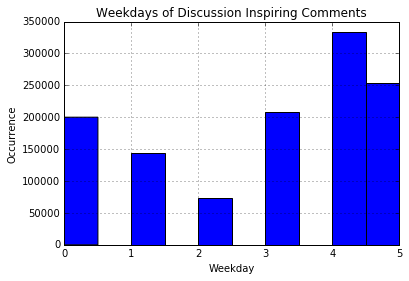

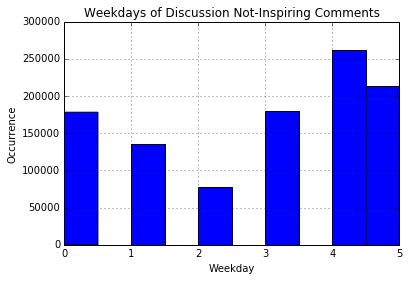

Loading Reddit2ndDevTime
Loaded Reddit2ndDevTime
Pearson Correlation Coefficient: (0.025611454084000913, 2.867153506944432e-42)
X1 Mean: 2.90017203792714, X0 Mean: 2.8091497262738794
X1 Median: 3.0, X0 Median: 3.0
X1 Std: 1.7656536658506297, X0 Std: 1.77758949209671


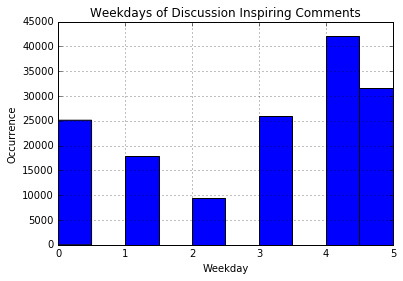

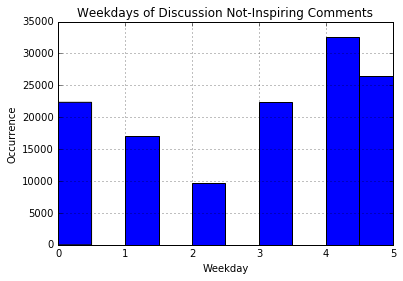

In [14]:
def check_correlation(filename, feature):
    vocabulary = set()
    X, y = load_comments(filename, feature, vocabulary)
    p = pearsonr(X, y)
    print("Pearson Correlation Coefficient: {}".format(p))
    X1 = []
    X0 = []
    for i in range(len(y)):
        if y[i] == 1:
            X1.append(X[i])
        else:
            X0.append(X[i])
    print("X1 Mean: {}, X0 Mean: {}".format(np.mean(X1), np.mean(X0)))
    print("X1 Median: {}, X0 Median: {}".format(np.median(X1), np.median(X0)))
    print("X1 Std: {}, X0 Std: {}".format(np.std(X1), np.std(X0)))

    plt.hist(X1)
    plt.xlabel("Weekday")
    plt.ylabel("Occurrence")
    plt.title("Weekdays of Discussion Inspiring Comments")
    plt.grid(True)
    plt.show()
    
    plt.hist(X0)
    plt.xlabel("Weekday")
    plt.ylabel("Occurrence")
    plt.title("Weekdays of Discussion Not-Inspiring Comments")
    plt.grid(True)
    plt.show()

# check_correlation('Reddit2ndTrainTime', weekday)
check_correlation('Reddit2ndTrainTime', time_of_day)
check_correlation('Reddit2ndDevTime', time_of_day)